In [1]:
import numpy as np
from shapely.geometry import Polygon,LineString
from shapely import affinity
from descartes.patch import PolygonPatch
from matplotlib import pyplot
import random
from figures import BLUE, SIZE, set_limits, plot_coords, color_isvalid,RED

In [2]:
max_x = 200
max_y = 300
num_chrom = 10

In [3]:
lis_coor = np.random.randint(max_x, size=num_chrom)
lis_coor = np.random.randint(max_y, size=num_chrom)

In [47]:
def binary_form(value,x=0):
    #max Y - 255 , Y - 511
    binary= (format(value,'08b'))
    binary2= (format(value,'09b'))
    if x==0:
        res = list(binary)
    if x==1:
        res = list(binary2)
    return res

def decoder(binary):
    binary = ''.join(binary)
    return int(binary,2)
def poligonbuild(shape,n):
    g = []
    for i in range(0,n):
        f = Polygon(shape)
        g.append(f)
    return g
def list_center(g): 
    cen_list = np.array([[0,0]])
    for i in range (0,len(g)):
        cen_list = np.concatenate((cen_list,[g[i].centroid.bounds[0:2]]))
    cen_list = np.delete(cen_list,0,axis=0)
    return cen_list

def update_center(g,new_center,new_teta):
    g_new = g
    for i in range(0,len(g_new)):
        off_pos  = new_center[i] - g_new[i].centroid.bounds[0:2][0]
        g_new[i] = affinity.translate(g_new[i],xoff=off_pos[0],yoff=off_pos[1])
        g_new[i] = affinity.rotate(g_new[i],angle=new_teta[i],origin='centroid')
    return g_new

def update_center2(g,new_center,new_teta):
    g_new = g[-1]
    off_pos  = new_center[-1] - g_new.centroid.bounds[0:2][0]
    g_new = affinity.translate(g_new,xoff=off_pos[0],yoff=off_pos[1])
    g_new = affinity.rotate(g_new,angle=new_teta[-1],origin='centroid')
    g[-1] = g_new
    return g

#Combine detect intersection and boundpenalties

def detect_intersection2(f,yMax=200,xMax=200):
    xMin = 0
    yMin = 0
    result = False
    for i in f:
        minPolyX = i.bounds[0]
        minPolyY = i.bounds[1]
        maxPolyX = i.bounds[2]
        maxPolyY = i.bounds[3]
        if minPolyY < yMin:
            #print('out of boundary')
            result = True
            return result
        if minPolyX < xMin:
            #print('out of boundary')
            result = True
            return result
        if maxPolyY > yMax:
            #print('out of boundary')
            result = True
            return result
        if maxPolyX > xMax:
            #print('out of boundary')
            result = True
            return result

    for i in range  (0,len(f)):
        if result:
            break
        for ii in range (i+1,len(f)):
            result =  (f[i].intersects(f[ii]))
            if result:
                #print('Intersect')
                break
    return result

def init_pop(poly_list,max_search,y_space,num_chrom):
    list_xy = []
    while(True):
        poly_list = poly_list
        ori_cntr= list_center(poly_list)
        new_pos = ori_cntr.copy()

        x = np.random.randint(max_search,size=1)[0]
        y = np.random.randint(y_space,size=1)[0]
        new_teta = np.zeros([1,len(poly_list)]).astype(int)[0]

        list_teta  = [0,30,45,60,90,120,135,150,180,210,225,240,270,300,315,330]
        teta = random.choice(list_teta)

        xy = [x,y]
#         print(xy)
        new_teta[-1] = teta
        new_pos[-1] = xy
        new_shape = update_center2(poly_list.copy(),new_pos,new_teta)
#         print(detect_intersection(new_shape))
        if detect_intersection(new_shape)==False:
#             print(new_shape[-1].bounds)
            xy = [x,y,teta]
            list_xy.append(xy)
        if len(list_xy)>num_chrom:
            break
    return list_xy
#selection
def do_crosover(sorted_area,new_pos):
    new_after =[]
    for i in range(0,len(sorted_area),2):
        #Do Cross-Over
        a = new_pos[sorted_area[i]]
        b = new_pos[sorted_area[i+1]]

        new = crossing(a,b)
        new_after.append(new[0])
        new_after.append(new[1])
        #new_pos[sorted_area[0]]
    return new_after


def max_stage_before(list_of_poly):
    list_of_poly = list_of_poly[0:-1]
    maxX = 0
    for i in list_of_poly:
        if i.bounds[2]>maxX:
            maxX = i.bounds[2]
        else:
            maxX = maxX
    return maxX

def length_new_shape(list_of_poly):
    list_of_poly = list_of_poly[-1]
    return list_of_poly.bounds[2]

def detect_intersection(f):
    result = False
    
    xMin = 0
    yMin = 0
    
    minPolyX = f[-1].bounds[0]
    minPolyY = f[-1].bounds[1]
    maxPolyX = f[-1].bounds[2]
    maxPolyY = f[-1].bounds[3]
    if minPolyY < yMin:
#         print('out of boundary')
        result = True
        return result
    if minPolyX < xMin:
#         print('out of boundary')
        result = True
        return result
    if maxPolyY>100:
#         print('Out of bonds')
        result = True
        return result
    
    for i in range  (0,len(f)):
        if result:
            break
        for ii in range (i+1,len(f)):
            result =  (f[i].intersects(f[ii]))
            if result:
                break
    return result

def calc_area(list_shape):
    x_max_coor = 0
    y_max_coor = 0
    for i in list_shape:
        coor = np.asarray(list(i.boundary.coords)).astype(int)
        y = [row[1] for row in coor]
        x = [row[0] for row in coor]
        if np.max(x)>x_max_coor:
            x_max_coor = np.max(x)
        if np.max(y)>y_max_coor:
            y_max_coor = np.max(y)
        else:
            x_max_coor=x_max_coor
            y_max_coor=y_max_coor
    area = x_max_coor*y_max_coor
    return area

def fitness(new_pos,list_shape_fix):
    ori_sh = list_shape_fix.copy()
    area = []
    for i in range(0,len(new_pos)):
        new_teta     = np.zeros([1,len(ori_sh)]).astype(int)[0]
        new_teta[-1] = new_pos[i][2]
        ori_cntr     = list_center(ori_sh)
        new_posX     = ori_cntr.copy()
        new_posX[-1] = [new_pos[i][0],new_pos[i][1]]
        new_shape    = update_center(list_shape_fix.copy(),new_posX,new_teta)
        if detect_intersection(new_shape):
            areas = calc_area(new_shape)
            areas = 100*areas
        else:
            areas = calc_area(new_shape)
        area.append(areas)
    return np.asarray(area)
#         print(calc_area(new_shape))

#do crossover
#offspring1

def crossing(a,b):
    alpha = np.random.uniform(0,1)
    beta  = 1-alpha
    cx    = int(alpha*a[0]+(beta*b[0]))
    cy    = int(alpha*a[1]+(beta*b[1]))
    cteta = int(alpha*a[2]+(beta*b[2]))
    cteta = round(cteta / 45) * 45
    off1  = [cx,cy,cteta]
    cx    = do_mutate(cx,x=1)
    cy    = do_mutate(cy,x=0)
    #offspring2
    alpha = np.random.uniform(0,1)
    beta  = 1-alpha
    cx    = int(alpha*a[0]+(beta*b[0]))
    cy    = int(alpha*a[1]+(beta*b[1]))
    cteta = int(alpha*a[2]+(beta*b[2]))
    cteta = round(cteta / 45) * 45
    off2  = [cx,cy,cteta]
    cx    = do_mutate(cx,x=1)
    cy    = do_mutate(cy,x=0)
    return [off1,off2]


def do_mutate(c,x):
    if x==1:
        var = (max_search-0)
    if x==0:
        var = max_y-0
    u = np.random.uniform(0,1)
    u = -1*u
    k = 8
    a = pow(2,(u*k))
    r = 0.7
    s = [-1,1]
    sc= random.choice(s)
    
    res = c+(sc*r*a)
    return res

def plot_all(g):
    fig = pyplot.figure(1, figsize=(15,5))
    ax = fig.add_subplot(121)
    ax.grid()
    axes = fig.gca()
    axes.set_xlim([0,400])
    axes.set_ylim([0,300])
    for i in range(0,len(g)):
        polygon= g[i]
        patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon,valid=BLUE), alpha=0.5, zorder=2)
        ax.add_patch(patch)

In [5]:
# Build the  real shape
sh1 = [[0,0],[0,20],[30,10]]
sh2 = [[0,0],[0,20],[20,20],[20,0]]
sh3 = [[0,0],[0,20],[20,40],[40,0]]
sh4 = [[0,0],[0,20],[40,20],[40,0]]

#Example poligon have this constraint
g1 = poligonbuild(sh1,3)
g2 = poligonbuild(sh2,2)
g3 = poligonbuild(sh3,4)
g4 = poligonbuild(sh4,2)
g  = g1+g2+g3+g4
f  = list_center(g)

In [6]:
#init
#What number of shape? 
n = np.random.randint(len(f), size=1)
#What position
xy = np.random.randint(255, size=2)
xy = [xy[0],xy[1]]
xy
#What angle
list_teta  = [0,30,45,60,90,120,135,150,180,210,225,240,270,300,315,330]
teta = random.choice(list_teta)

In [7]:
new_pos = f.copy()
new_pos[n] = xy
new_teta = np.zeros([1,len(f)]).astype(int)[0]
new_teta[n] = teta
g_new = update_center(g.copy(),new_pos,new_teta)

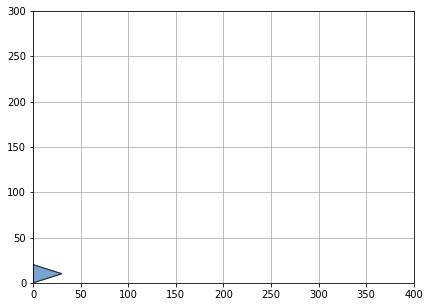

In [8]:
plot_all(g_new[0:3])

In [61]:
#Whats is the schedule?
list_g = g.copy()
random.shuffle(list_g)

In [62]:
def max_search_space(list_of_poly,maximumY=100):
    ymax = 0
    for i in gg:
        if i.bounds[3]>ymax:
            ymax = i.bounds[3]
        else:
            ymax =  ymax
            
    if list_of_poly[-1].bounds[3]+ymax > maximumY:
        
        max_X = max_stage_before(list_of_poly) + 5 + length_new_shape(list_of_poly)
    else:
        max_X = max_stage_before(list_of_poly)
    
    return max_X

In [107]:
#Optimize with GA
gg = list_g[0]
i = 1
gg = np.append(gg,list_g[i])

#Update Search Space 
max_search = max_search_space(gg)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg,max_search,y_space,25)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
# Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)
#     print(min(area_after))
# for i in range(1,len(list_g)):
#     list_g[1]

1155
1100
POINT (16 46)


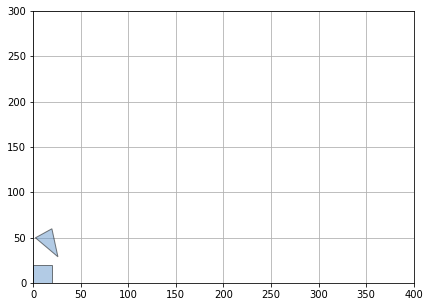

In [108]:
plot_all(new_shape)

In [109]:
for i in range(2,5):

    gg = new_shape.copy()
    gg = np.append(gg.copy(),list_g[i])
    #print(gg.copy()[1].centroid.wkt)

    maximum_y_before=0
    for i in new_shape:
        if maximum_y_before < i.bounds[3]:
            maximum_y_before=i.bounds[3]

    max_search = max_search_space(gg)
    y_space    = max(gg[-1].bounds)*2
    #GA Kan
    #Initial Population
    new_pos = init_pop(gg.copy(),max_search,y_space,25)
    # print(new_pos)
    # check fitness
    area = fitness(new_pos.copy(),gg.copy())
    print(min(area))
    #do selection & crosover
    best_pos= new_pos[np.argmin(area)]
    area_after = area
    a = min(area)
    for ii in range(0,1000):
        sorted_area = np.argsort(area_after.copy())
        new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
        area_now = fitness(new_poss.copy(),gg.copy())
        if min(area_now)<a:
            best_pos = new_pos[np.argmin(area_now)]
            a        = min(area_now)
        else:
            best_pos = best_pos
            a        = a

        area_after = area_now

    #Pretend the output is 
    print(best_pos)
    print(a)
    print('########')
    
    new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
    new_teta[-1] = best_pos[2]
    ori_cntr     = list_center(gg.copy())
    new_posX     = ori_cntr.copy()
    new_posX[-1] = [best_pos[0],best_pos[1]]
    new_shape    = update_center2(gg.copy(),new_posX,new_teta)

    #print(new_shape.copy()[1].centroid.wkt)

357200
[24, 79, 330]
7003
[37, 13, 90]
9238
[52, 64, 270]


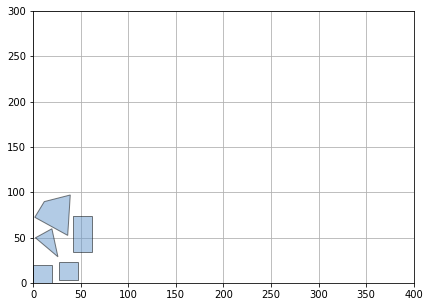

In [110]:
plot_all(new_shape)

### **SUDAH SAMPAI SINI SAJA**

In [85]:
gg = new_shape.copy()
i = 3
gg = np.append(gg.copy(),list_g[i])
print(gg.copy()[1].centroid.wkt)

maximum_y_before=0
for i in new_shape:
    if maximum_y_before < i.bounds[3]:
        maximum_y_before=i.bounds[3]
        
max_search = max_search_space(gg)
print(max_search)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg.copy(),max_search,y_space,3)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
#Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)

POINT (16 41)
64.97606774342518
6660
6512
POINT (16 41)


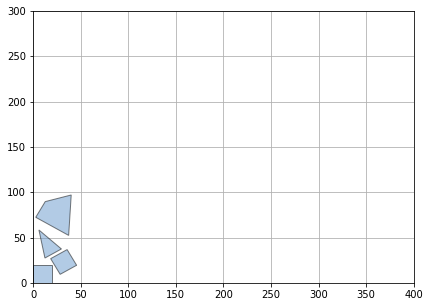

In [86]:
plot_all(new_shape)

In [88]:
gg = new_shape.copy()
i = 4
gg = np.append(gg.copy(),list_g[i])
print(gg.copy()[1].centroid.wkt)

maximum_y_before=0
for i in new_shape:
    if maximum_y_before < i.bounds[3]:
        maximum_y_before=i.bounds[3]
        
max_search = max_search_space(gg)
print(max_search)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg.copy(),max_search,y_space,15)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
#Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)

POINT (16 41)
90.66025403784438
1243200
1065600
POINT (16 41)


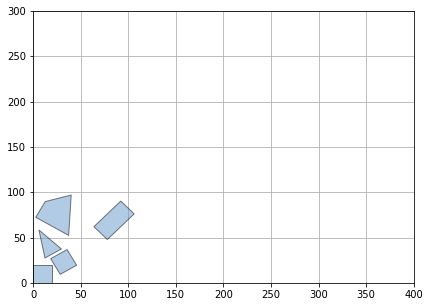

In [89]:
plot_all(new_shape)

In [90]:
gg = new_shape.copy()
i = 5
gg = np.append(gg.copy(),list_g[i])
print(gg.copy()[1].centroid.wkt)

maximum_y_before=0
for i in new_shape:
    if maximum_y_before < i.bounds[3]:
        maximum_y_before=i.bounds[3]
        
max_search = max_search_space(gg)
print(max_search)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg.copy(),max_search,y_space,15)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
#Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)

POINT (16 41)
151.21320343559643
1568800
1568800
POINT (16 41)


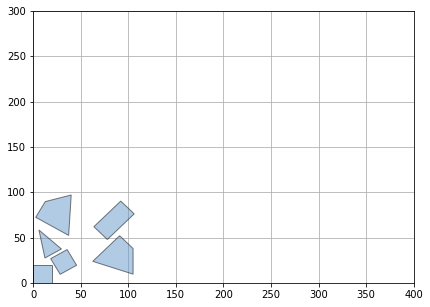

In [91]:
plot_all(new_shape)

In [92]:
gg = new_shape.copy()
i = 6
gg = np.append(gg.copy(),list_g[i])
print(gg.copy()[1].centroid.wkt)

maximum_y_before=0
for i in new_shape:
    if maximum_y_before < i.bounds[3]:
        maximum_y_before=i.bounds[3]
        
max_search = max_search_space(gg)
print(max_search)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg.copy(),max_search,y_space,15)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
#Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)

POINT (16 41)
151.21320343559643
1968400
1968400
POINT (16 41)


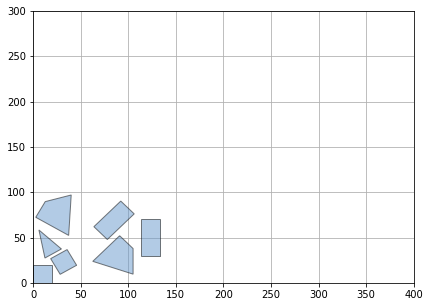

In [93]:
plot_all(new_shape)

In [94]:
gg = new_shape.copy()
i = 7
gg = np.append(gg.copy(),list_g[i])
print(gg.copy()[1].centroid.wkt)

maximum_y_before=0
for i in new_shape:
    if maximum_y_before < i.bounds[3]:
        maximum_y_before=i.bounds[3]
        
max_search = max_search_space(gg)
print(max_search)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg.copy(),max_search,y_space,15)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
#Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)

POINT (16 41)
168.0
1968400
1968400
POINT (16 41)


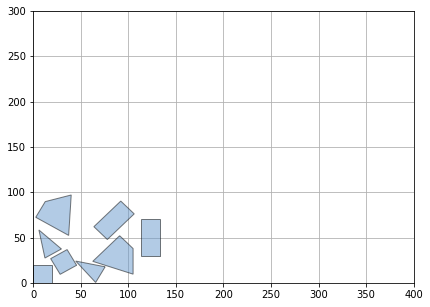

In [95]:
plot_all(new_shape)

POINT (16 41)
178.0
2649200
2545600
POINT (16 41)


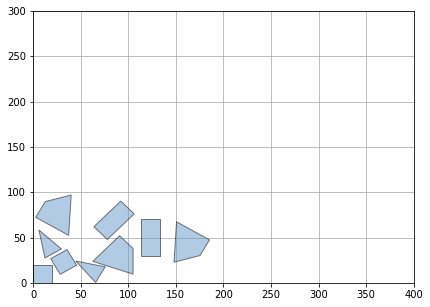

In [96]:
gg = new_shape.copy()
i = 8
gg = np.append(gg.copy(),list_g[i])
print(gg.copy()[1].centroid.wkt)

maximum_y_before=0
for i in new_shape:
    if maximum_y_before < i.bounds[3]:
        maximum_y_before=i.bounds[3]
        
max_search = max_search_space(gg)
print(max_search)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg.copy(),max_search,y_space,15)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
#Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)
plot_all(new_shape)

POINT (16 41)
220.34444033226362
2738000
2738000
POINT (16 41)


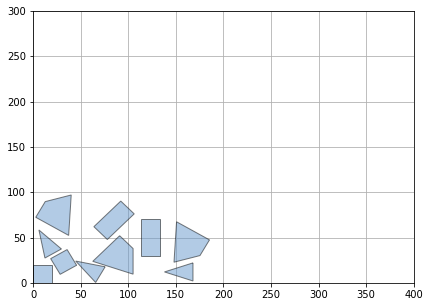

In [97]:
gg = new_shape.copy()
i = 9
gg = np.append(gg.copy(),list_g[i])
print(gg.copy()[1].centroid.wkt)

maximum_y_before=0
for i in new_shape:
    if maximum_y_before < i.bounds[3]:
        maximum_y_before=i.bounds[3]
        
max_search = max_search_space(gg)
print(max_search)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg.copy(),max_search,y_space,15)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
#Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)
plot_all(new_shape)

POINT (16 41)
230.34444033226362
3196800
3137600
POINT (16 41)


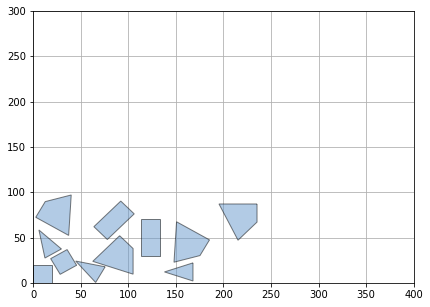

In [98]:
gg = new_shape.copy()
i = 10
gg = np.append(gg.copy(),list_g[i])
print(gg.copy()[1].centroid.wkt)

maximum_y_before=0
for i in new_shape:
    if maximum_y_before < i.bounds[3]:
        maximum_y_before=i.bounds[3]
        
max_search = max_search_space(gg)
print(max_search)
y_space    = max(gg[-1].bounds)*2
#GA Kan
#Initial Population
new_pos = init_pop(gg.copy(),max_search,y_space,15)
# print(new_pos)
# check fitness
area = fitness(new_pos.copy(),gg.copy())
print(min(area))
#do selection & crosover
best_pos= new_pos[np.argmin(area)]
area_after = area
a = min(area)
for ii in range(0,1000):
    sorted_area = np.argsort(area_after.copy())
    new_poss = do_crosover(sorted_area.copy(),new_pos.copy())
    area_now = fitness(new_poss.copy(),gg.copy())
    if min(area_now)<a:
        best_pos = new_pos[np.argmin(area_now)]
        a        = min(area_now)
    else:
        best_pos = best_pos
        a        = a
        
    area_after = area_now
    
#Pretend the output is 
# best_pos = [19, 68, 0]
print(a)
new_teta     = np.zeros([1,len(gg.copy())]).astype(int)[0]
new_teta[-1] = best_pos[2]
ori_cntr     = list_center(gg.copy())
new_posX     = ori_cntr.copy()
new_posX[-1] = [best_pos[0],best_pos[1]]
new_shape    = update_center2(gg.copy(),new_posX,new_teta)

print(new_shape.copy()[1].centroid.wkt)
plot_all(new_shape)